#**Automatic Differentiation**

In this notebook, I'm going to demonstrate GradientTape(), a function that implements a computation graph, to automate the evaluation of partial derivatives. Here, we define a function, y = x^2, we define a gradientTape, and then we call the gradient() function to evaluate the first derivative of that function with respect to one parameter of that function, in this case x. Note that a tf.Variable() is a tensor that can hold mutable (changeable) values. Here I have defined x as a scalar.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

# f(x) = x^2; f'(x) = 2x; numerical evaluation of 2x when x = 3 is 2*3 = 6.
print(f'The first derivative of x^2 is {tape.gradient(y,x).numpy()}')

The first derivative of x^2 is 6.0


We can also nest tapes to take a second derivative, like so:

In [ ]:
with tf.GradientTape() as tape2:
  # If we don't specify 'persistent = True' then the tape is dropped from memory after the first gradient is evaluated.
  with tf.GradientTape(persistent=True) as tape:
     y=x**2

  dy_dx = tape.gradient(y,x)
  print(f'The first derivative of x^2 is 2x; 2 * 3 = {dy_dx.numpy()}')

d2y_dx = tape2.gradient(dy_dx,x)

print(f'The second derivative of x^2 is {d2y_dx.numpy()}')

The first derivative of x^2 is 2x; 2 * 3 = 6.0
The second derivative of x^2 is 2.0


We can also use tapes with higher dimensional tensors, e.g., here is an example for a sigmoid neuron. In the code below, note that w@x is tensor multiplication. Be careful with the order of the matrices and their dimensions; the matrix multiplication will only work if the shapes align. Also note that reduce_mean() returns the average over elements of y. We can directly obtain the gradient of the loss function w.r.t. our w and b parameters. The resulting gradients will be the same shape as the argument we are taking gradient with respect to, i.e., w.shape and b.shape. So, when we update values in a back pass, we can just calculate w -= dl_dw * learning_rate. and b -= dl_db * learning_rate.

In [ ]:
w = tf.Variable(tf.random.normal((3,1),dtype=tf.float32),name='w')
b = tf.Variable(tf.ones(1,dtype=tf.float32),name='b')
x = tf.constant([[1., 2., 5.]])

# x is a 1x3 vector; w is a 3x1 matrix. So, 1x3 * 3*1 = 1x1 result, and adding a 1x1 bias (scalar) gives coherent output of the same shape.
print(f"The shape of x*w+b will be: {(x@w+b).numpy().shape}\n")

with tf.GradientTape() as tape:
  y = x @ w + b
  z = tf.sigmoid(y)
  # how am I operationalizing error here; what is my implicit ground truth?
  loss = tf.reduce_mean(z)

[dl_dw,dl_db] = tape.gradient(loss,[w,b])
print(f'The gradients of loss w.r.t. weights is\n{dl_dw}\n The gradient w.r.t. b is {dl_db}.')

The shape of x*w+b will be: (1, 1)

The gradients of loss w.r.t. weights is
[[0.00179183]
 [0.00358366]
 [0.00895916]]
 The gradient w.r.t. b is [0.00179183].


Let's do the same thing, but using a dictionary instead of a list...

In [ ]:
with tf.GradientTape() as tape:
  y = x @ w + b
  z = tf.sigmoid(y)
  loss = tf.reduce_mean(z)

my_parms = {
    'w': w,
    'b': b
}

gradients = tape.gradient(loss,my_parms)
gradients['w']

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.00179183],
       [0.00358366],
       [0.00895916]], dtype=float32)>

#**Gradient Descent with a Simple Neural Network**

Okay, now let's apply GradientTape to a mock neural network. We have our input layer of x's (4 features), and then a 3-node hidden layer employing ReLU activations, followed by a 4-node hidden layer employing tanh activations, followed by a single output node, employing sigmoid, for a binary DV. Our loss function will be the average of squared predictions. Note that this isn't really a meaningful NN; it's just for show. This definition means we have 3*2 = 6 weights and 2 bias terms.

In [ ]:
# Dense implements the operation: output = activation(dot(input, weights) + bias).
# Units = 2 means we have two nodes in the layer.
# We have 4 inputs, a hidden layer with 2 nodes, thus 4x2 = 8 weights, randomly initialized;
# The vector of 2 bias terms will initially default to values of 0.
# We then have a sigmoid output layer, e.g., a binary classification scenario, which takes 2 inputs, thus 2*1 = 2 weights, 1 bias term.
model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2, activation="relu", name="hiddenLayer"),
        tf.keras.layers.Dense(units=1, activation="linear",name="outputLayer"),
])

# Here is a random vector of 4 values, e.g., representing a single training observation.
input = tf.random.normal((1,4))

In [ ]:
prediction = model(input)
model.trainable_variables

[<tf.Variable 'hiddenLayer/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[ 0.8260925 ,  0.61075664],
        [-0.12604976, -0.58342147],
        [ 0.30424738,  0.37729406],
        [ 0.01328421,  0.27385664]], dtype=float32)>,
 <tf.Variable 'hiddenLayer/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'outputLayer/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.86553544],
        [ 0.52753055]], dtype=float32)>,
 <tf.Variable 'outputLayer/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

Now we can apply GradientTape, in a loop, conducting a forward pass and then recovering gradients for all model parameters, and finally updating our parameters in the opposite direction from the gradients. We will iterate and repeat this process 100 times. Note, if we were doing this with N training examples, we would instead take the average loss across them. So, loss would equal tf.reduce_mean((prediction-target)**2)). We are sticking with a single training data point here for simplicity's sake.

In [ ]:
import numpy as np

# Define our learning rate and our ground truth value for our single training observation.
learning_rate = 1e-3
target=15

history = []
for i in range(120):
  with tf.GradientTape() as tape:
    # Forward pass
    prediction = model(input)
    # We define our loss as the square of the forward pass prediction - 3.
    # 'target' is the true value, and we are taking the squared loss with respect to that value.
    loss = (prediction-target)**2

  # Gradients with respect to every trainable variable, i.e., backward pass.
  grad = tape.gradient(loss, model.trainable_variables)
  for i in range(len(model.trainable_variables)):
    new_parms = model.trainable_variables[i] - grad[i]*learning_rate
    model.trainable_variables[i].assign(new_parms)

  history.append(prediction.numpy())

# Finally, collapse the list of arrays into a single array.
history = np.concatenate(history, axis=0)

Finally, we can plot the optimization process, showing how our model gradually improves until it predicts the correct value.

Text(0.5, 1.0, 'Optimization of a Simple NN')

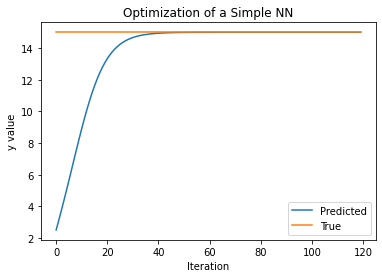

In [ ]:
# Plot the evolution of our predictions as we tweak our network's weights and bias.
# Eventually, it converges to the correct prediction.
plt.plot(range(120),history,[target]*120)
plt.legend(('Predicted','True'))
plt.xlabel('Iteration')
plt.ylabel('y value')
plt.title('Optimization of a Simple NN')

We can see what the final parameter values are in the fitted model...

In [ ]:
model.layers[0].get_weights()

[array([[-1.1726863 , -1.2067394 ],
        [ 0.23990153, -0.81552476],
        [-0.5164312 , -0.45791358],
        [ 1.5685458 ,  1.1876186 ]], dtype=float32),
 array([0.4360297 , 0.42928943], dtype=float32)]

In [ ]:
model.layers[1].get_weights()

[array([[1.9490174],
        [1.8534218]], dtype=float32), array([0.2908994], dtype=float32)]

#**Gradient Tape Exercise**

Use tf.GradientTape() to plot the Hyperbolic Tangent activation function over input values ranging from -10 to 10, and overlay a plot of the first derivative of the activation function.

Notes:

* *Any variable you want to calculate a derivative with respect to should be declared as a tf.Variable().*
* *To convert a tf tensor into a numpy array, apply the .numpy() function to it.*
* *The tanh function is pre-defined for you in tf.nn.tanh(), as are some other activation functions.*

In [ ]:
import numpy as np

# Simulating some data for you to initialize x with. This is just a 200x1 array of random values between -10 and +10, sorted.
data = tf.sort(tf.random.uniform((200,1),minval=-10,maxval=10),axis=0)

x = ## Declare your variable.

with # Declare your tape
  y = ## Write your activation function here.

dy_dx = # Obtain gradient across values of x, from the tape, here.

# Create your plot
plt.plot()# arguments here are x and y)
plt.plot()# arguments here are x and the gradient values)
plt.legend(['Tanh','Tanh\''])
plt.show()